In [69]:
from collections import Counter, defaultdict
import glob
import itertools
import json
import matplotlib.pyplot as plt
import logomaker
import numpy as np
import pandas as pd
from scipy.stats import sem

import pyrepseq.plotting as pp
import sys
sys.path.append('..')
sys.path.append('../lib')
from lib import *
from lib.plotting import model_labels as labels
plt.style.use('../peptidome.mplstyle')
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## For original analyses and data derivation see https://github.com/andim/peptidome/tree/master/code/maxent and https://github.com/andim/peptidome/tree/master/code/netmhc

In [4]:
datadir = '../data/generated_data'

In [11]:
energy_human = make_energy(np.load(f'{datadir}/Human_nskewfcov_k9_params.npz'))
F_human = float(pd.read_csv(f"{datadir}/Human_nskewfcov_k9_entropy.csv",header=None, index_col=0).loc['F'].values[0])
loglikelihood_human   = lambda seq: -energy_human(seq) +F_human

In [30]:
human_peptides = load_matrix(f'{datadir}/Human_test_k9_matrix.csv.gz')
human_peptides_kmers = matrix_to_kmers(human_peptides)
human_peptides_likelihood = [loglikelihood_human(x) for x in human_peptides]

viral_peptides = load_matrix(f'{datadir}/Humanviruses_test_k9_matrix.csv.gz')
viral_peptides_likelihood = [loglikelihood_human(x) for x in viral_peptides]
viral_peptides_kmers = matrix_to_kmers(viral_peptides)


In [13]:
example_hlas = [
    'HLA-A0301',
    'HLA-A1101',
    'HLA-A0206',
    'HLA-A0203',
    'HLA-A0201',
    'HLA-B5801',
    'HLA-B0801',
    'HLA-B3501',
    'HLA-B0702',
    'HLA-B1501',
    'HLA-C0702',
    'HLA-C0602',
    'HLA-C0303',
    'HLA-C1203',
    'HLA-C1402'
]

In [23]:
def get_human_binders(hla):
    return set(pd.read_csv(f'{datadir}/netMHC_output/net_mhc_output_Human_test-{hla}.csv')['Peptide'].values)

def get_viral_binders(hla):
    return set(pd.read_csv(f'{datadir}/netMHC_output/net_mhc_output_Humanviruses_test-{hla}.csv')['Peptide'].values)

human_binders_dict = {hla: get_human_binders(hla) for hla in example_hlas}
viral_binders_dict = {hla: get_viral_binders(hla) for hla in example_hlas}


In [33]:
human_hla_data = {}
viral_hla_data = {}

for hla in example_hlas:
    
    human_peptides_restricted = [p for p in human_peptides_kmers if p in human_binders_dict[hla]]
    human_peptides_restricted_likelihood = [loglikelihood_human(x) for x in kmers_to_matrix(human_peptides_restricted)]
    human_hla_data[hla] = {
        'peptides': human_peptides_restricted, 'likelihoods': human_peptides_restricted_likelihood
    }
    viral_peptides_restricted = [p for p in viral_peptides_kmers if p in viral_binders_dict[hla]]
    viral_peptides_restricted_likelihood = [loglikelihood_human(x) for x in kmers_to_matrix(viral_peptides_restricted)]
    viral_hla_data[hla] = {
        'peptides': viral_peptides_restricted, 'likelihoods': viral_peptides_restricted_likelihood
    }


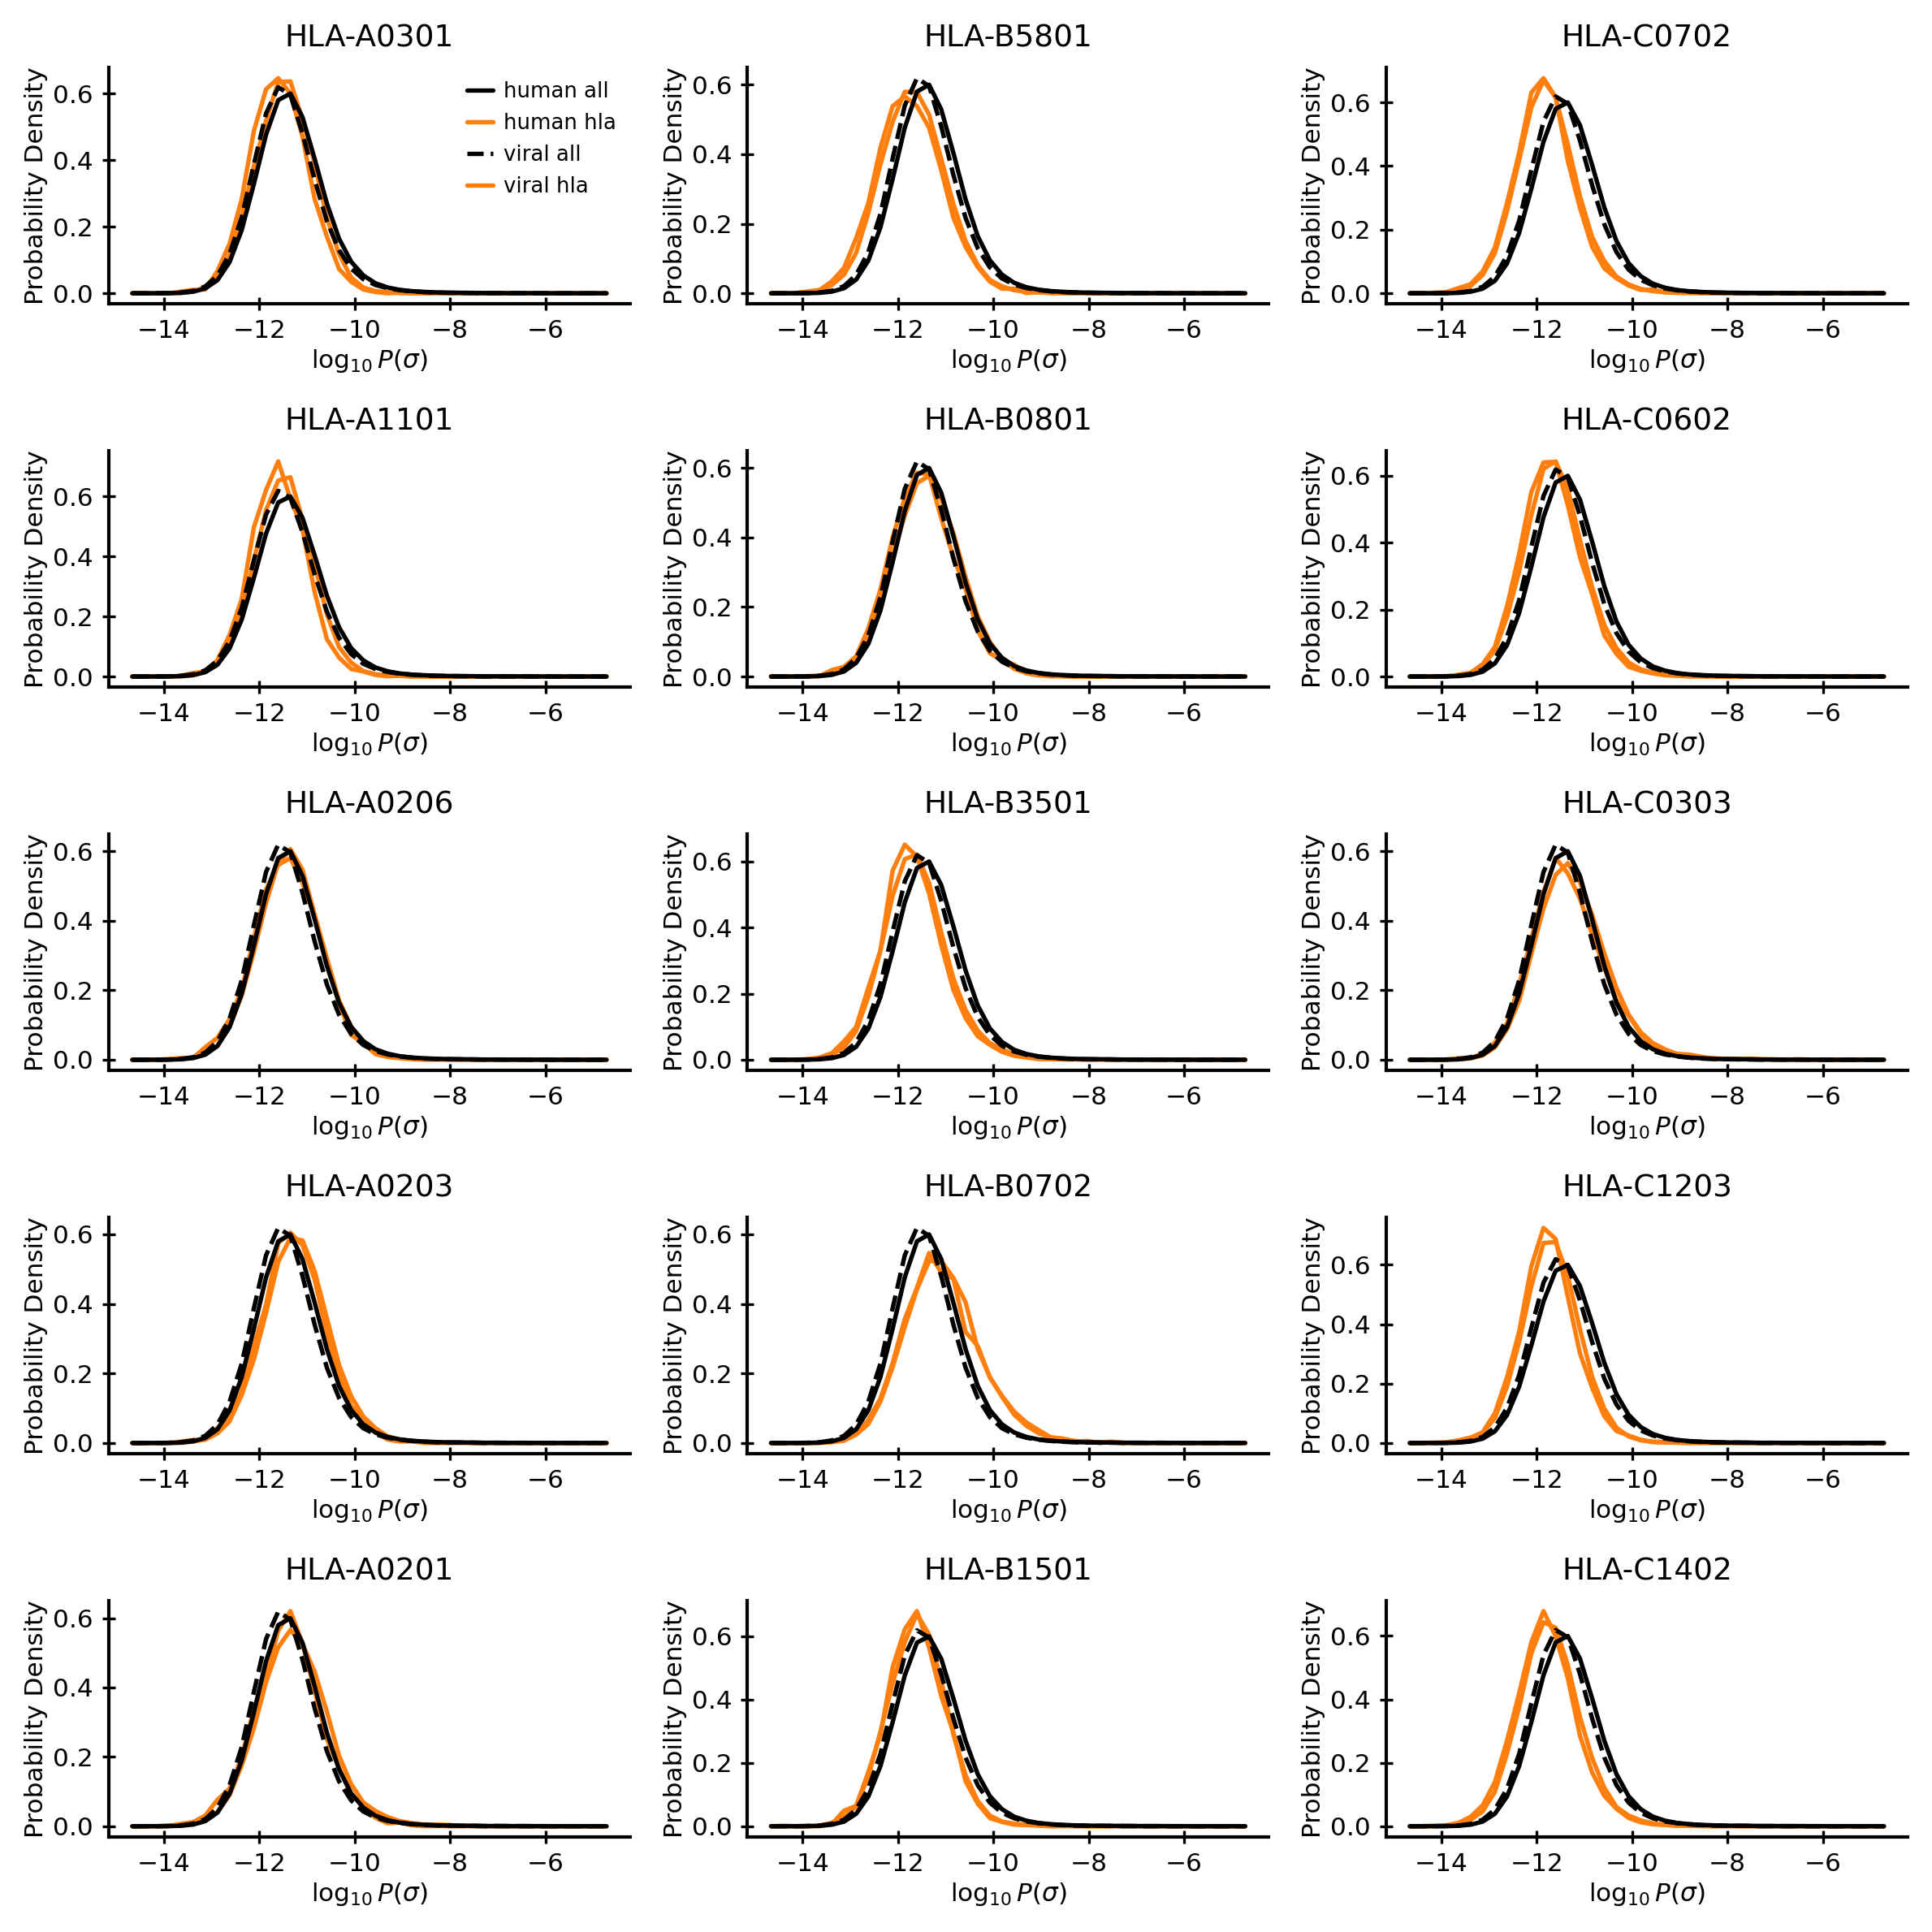

In [57]:

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(8, 8))
axes_list = [axes[row, col] for col in range(3) for row in range(5)]

xmax = max([max(human_peptides_likelihood),max(viral_peptides_likelihood)])
xmin = min([min(human_peptides_likelihood),min(viral_peptides_likelihood)])
xmax = (xmax/np.log(10)) +0.05
xmin = (xmin/np.log(10)) -0.05

nbins = 40
scaley = nbins/(xmax-xmin)
bins = np.linspace(xmin, xmax, num=nbins+1)

count=0
for hla in example_hlas:

    ax = axes_list[count]
    count += 1
    
    human_all = np.array(human_peptides_likelihood)/np.log(10)
    counts, bins = np.histogram(human_all, bins=bins)
    counts = (counts+1e-2)/np.sum(counts)
    ax.plot(bins[:-1], counts*scaley,
            label='human all', ls='-',
            color='k',
            zorder=1)

    human_hla = np.array(human_hla_data[hla]['likelihoods'])/np.log(10)
    counts, bins = np.histogram(human_hla, bins=bins)
    counts = (counts+1e-2)/np.sum(counts)
    ax.plot(bins[:-1], counts*scaley,
            label='human hla', ls='-',
            color='C1',
            zorder=0)
    
    viral_all  = np.array(viral_peptides_likelihood)/np.log(10)
        
    counts, bins = np.histogram(viral_all, bins=bins)
    counts = (counts+1e-2)/np.sum(counts)
    ax.plot(bins[:-1], counts*scaley,
            label='viral all', ls='--',
            color='k',
            zorder=1)

    viral_hla = np.array(viral_hla_data[hla]['likelihoods'])/np.log(10)
    counts, bins = np.histogram(viral_hla, bins=bins)
    counts = (counts+1e-2)/np.sum(counts)
    ax.plot(bins[:-1], counts*scaley,
            label='viral hla', ls='-',
            color='C1',
            zorder=0)
    
    
    ax.set_xlabel(r'$\log_{10} P(\sigma)$')

    ax.set_ylabel('Probability Density')
    ax.set_title(hla)

axes[0,0].legend(loc='upper right', fontsize='x-small')
fig.tight_layout()
# fig.savefig('hla_shifts.pdf')

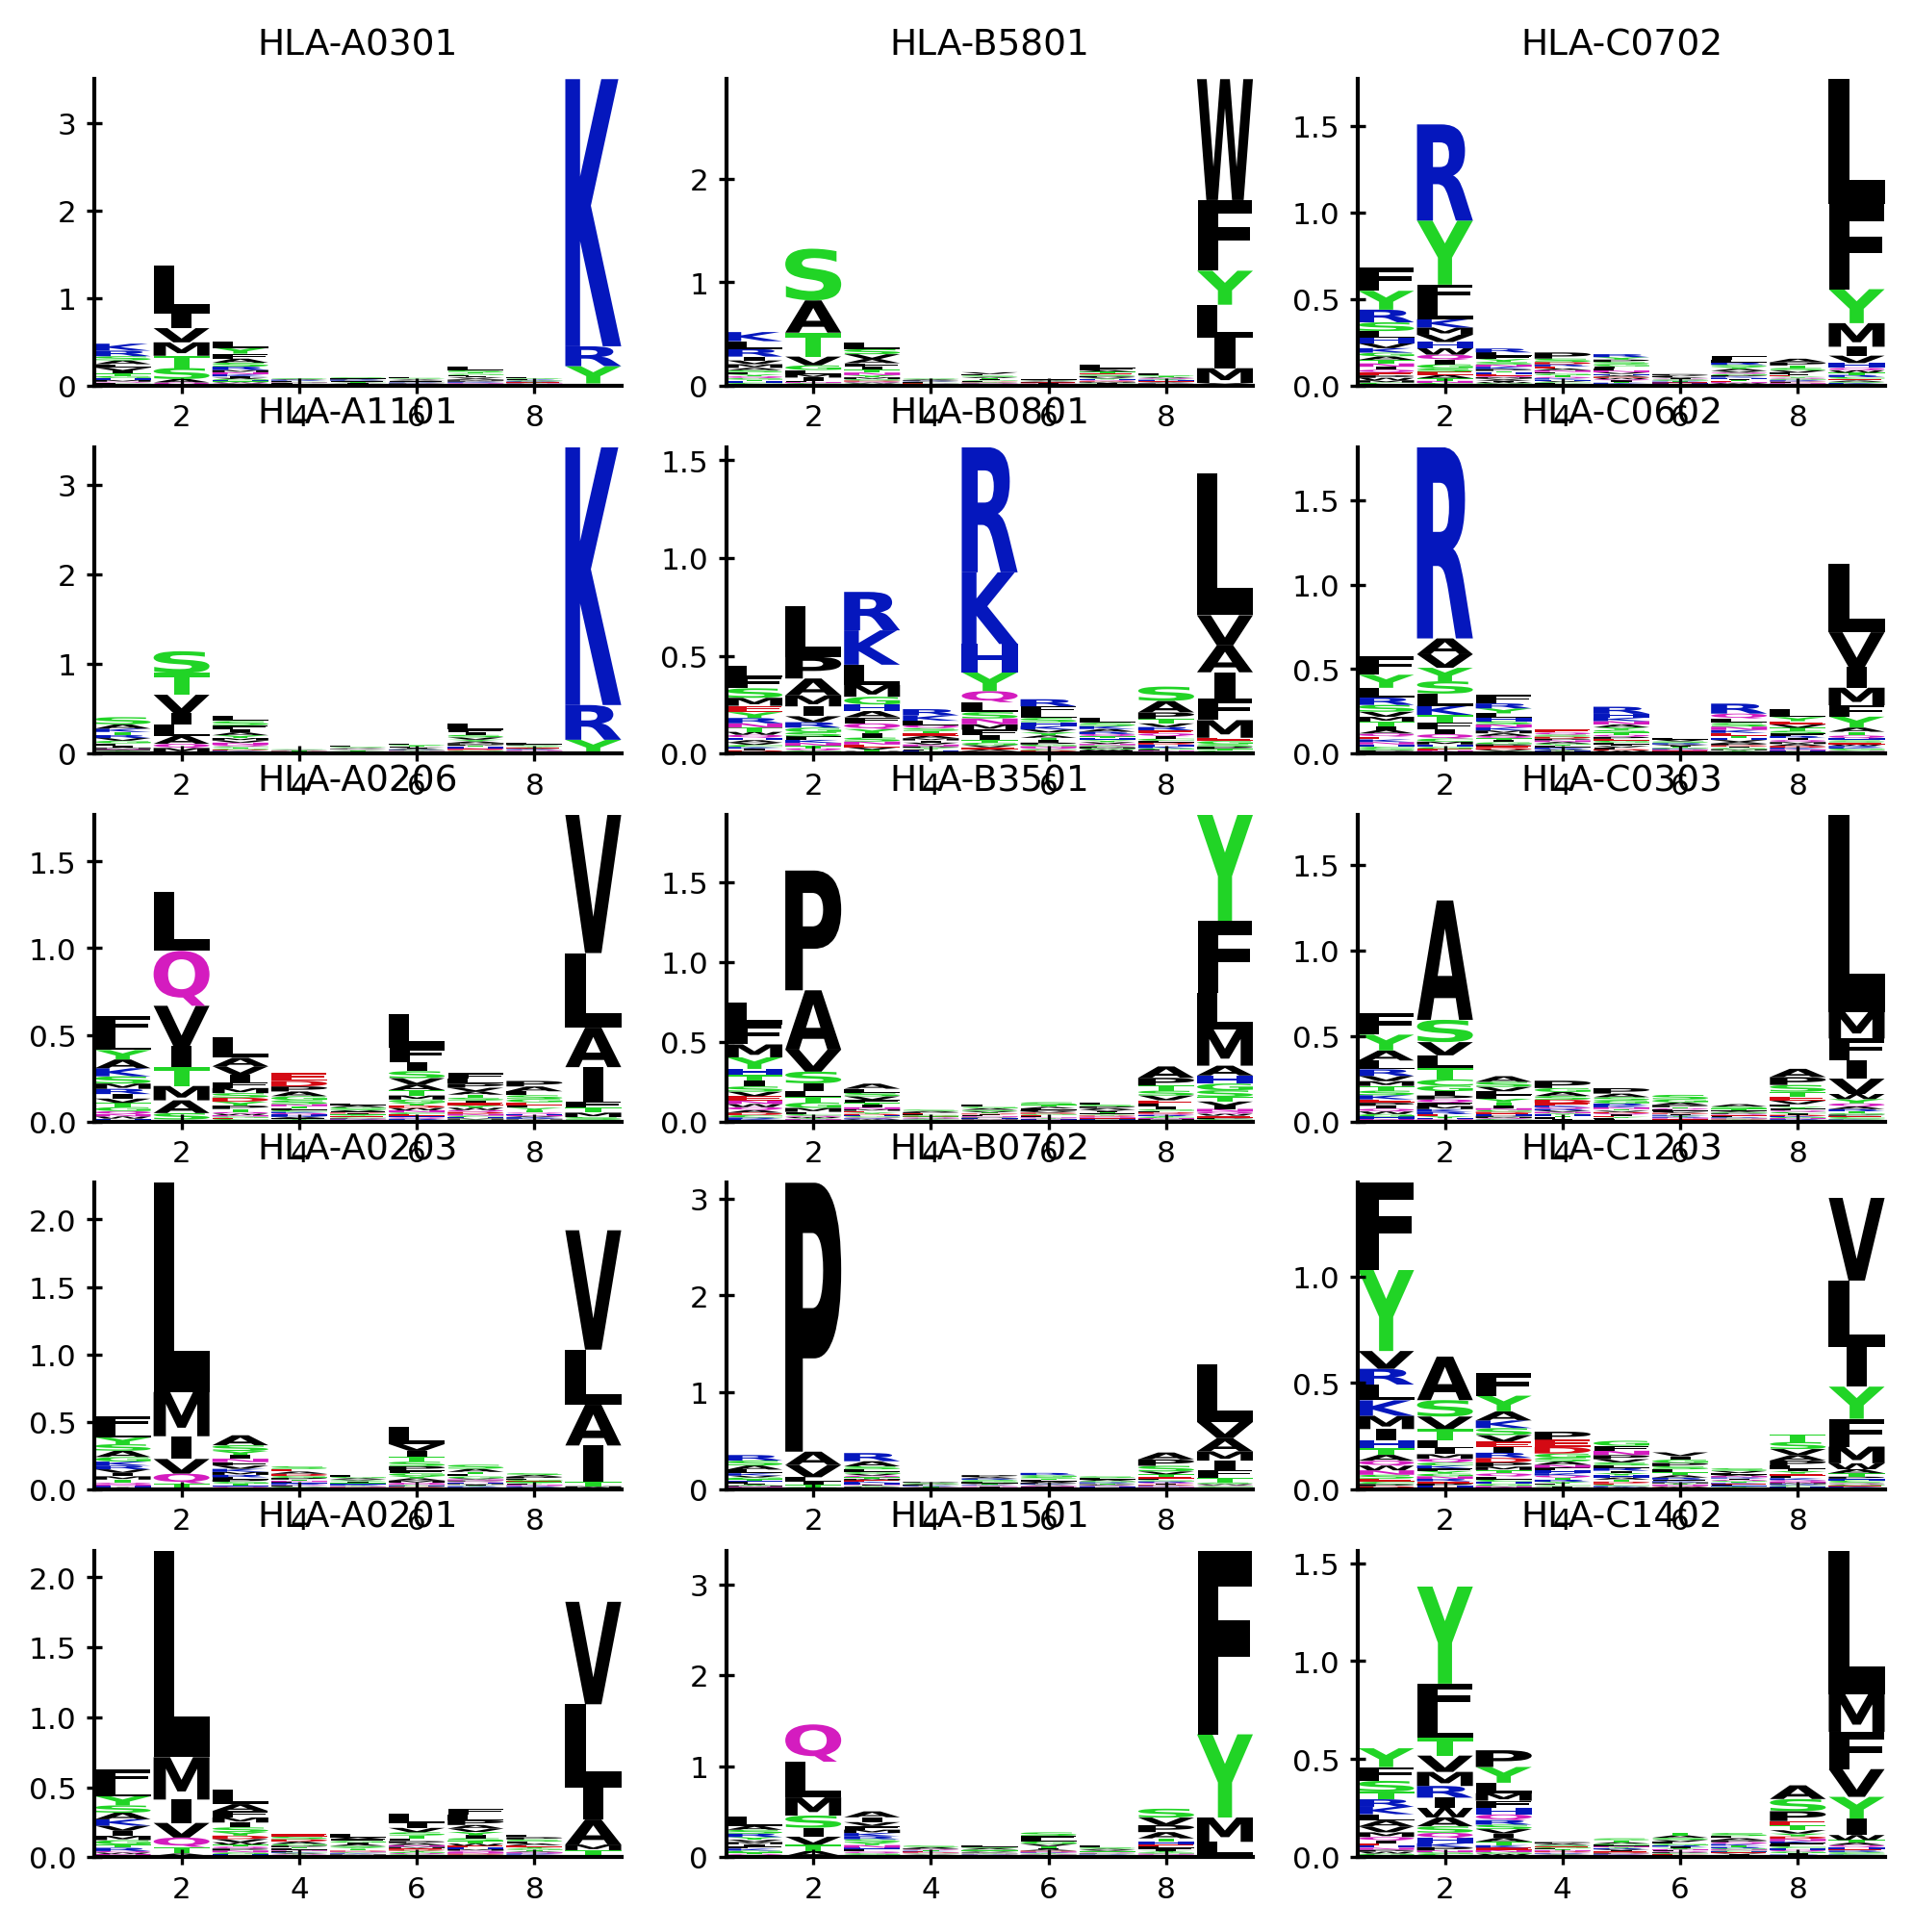

In [71]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(8, 8))
axes_list = [axes[row, col] for col in range(3) for row in range(5)]

all_peptides = human_peptides_kmers + viral_peptides_kmers
background = logomaker.alignment_to_matrix(all_peptides)


count=0
for hla in example_hlas:

    ax = axes_list[count]
    count += 1

    binders = list(human_binders_dict[hla].union(viral_binders_dict[hla]))
    information = logomaker.transform_matrix(logomaker.alignment_to_matrix(binders),
                                                     from_type='counts', to_type='information',
                                                     background=background)
    information.index += 1
    logo = logomaker.Logo(information,ax=ax)
    information.index += 1
    ax.set_title(hla)

    

## B and C

In [6]:
cols = ["A1","A2","B1","B2","C1","C2"]
haplotypes = pd.read_csv("../data/generated_data/top_500_allowed_haplotypes.txt",names=cols)

In [4]:
haplotypes

,A1,A2,B1,B2,C1,C2
0,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B0801,HLA-C0701,HLA-C0702
1,HLA-A0201,HLA-A0301,HLA-B0702,HLA-B0801,HLA-C0701,HLA-C0702
2,HLA-A0201,HLA-A0201,HLA-B0702,HLA-B0801,HLA-C0701,HLA-C0702
3,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B4402,HLA-C0701,HLA-C0702
4,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B0801,HLA-C0401,HLA-C0701
...,...,...,...,...,...,...
495,HLA-A0101,HLA-A0201,HLA-B0702,HLA-B4402,HLA-C0701,HLA-C0802
496,HLA-A0201,HLA-A0201,HLA-B0702,HLA-B4001,HLA-C0501,HLA-C0702
497,HLA-A0201,HLA-A0301,HLA-B0801,HLA-B4001,HLA-C0602,HLA-C0701
498,HLA-A0101,HLA-A0201,HLA-B1501,HLA-B4402,HLA-C0501,HLA-C0702


In [7]:
top_hap = haplotypes.loc[0]
list(top_hap)

['HLA-A0101', 'HLA-A0201', 'HLA-B0702', 'HLA-B0801', 'HLA-C0701', 'HLA-C0702']

## MHC and Classification

In [3]:
def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'../data/generated_data/netMHC_output/net_mhc_output_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        print(allele)
        mhc_df = get_mhc_df(model, allele)
        if mhc_df is not None:
            try:
                kmers = kmers.union(set(mhc_df['Peptide']))
            except Exception as e:
                print(f'Messed up CSV: {model},{allele}')
                print(e)
    return kmers

In [8]:
human_matrix = load_matrix('../data/generated_data/Human_test_k9_matrix.csv.gz')
human_binders = get_combined_binders('Human_test', list(top_hap))

human_kmers = matrix_to_kmers(human_matrix)
human_kmers_mhc = [km for km in human_kmers if km in human_binders]
human_matrix_mhc = kmers_to_matrix(human_kmers_mhc)

    
virus_matrix = load_matrix('../data/generated_data/Humanviruses_test_k9_matrix.csv.gz')
virus_binders = get_combined_binders('Humanviruses_test', list(top_hap))
virus_kmers = matrix_to_kmers(virus_matrix)
virus_kmers_mhc = [km for km in virus_kmers if km in virus_binders]
virus_matrix_mhc = kmers_to_matrix(virus_kmers_mhc)

HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702
HLA-A0101
HLA-A0201
HLA-B0702
HLA-B0801
HLA-C0701
HLA-C0702


In [9]:
logp_dict = {}
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
# models = ['ncov']


for model in models:
    
    
    
    # human values with and without MHC
    energy_human = make_energy(np.load(f'../data/generated_data/Human_{model}_k9_params.npz'))
    F_human = float(pd.read_csv(f"../data/generated_data/Human_{model}_k9_entropy.csv",header=None, index_col=0).loc['F'].values[0])
    loglikelihood_human  = lambda seq: -energy_human(seq) + F_human
    
    
    # virus values with and without MHC
    energy_virus = make_energy(np.load(f'../data/generated_data/Humanviruses_{model}_k9_params.npz'))
    F_virus = float(pd.read_csv(f'../data/generated_data/Humanviruses_{model}_k9_entropy.csv',header=None, index_col=0).loc['F'].values[0])
    loglikelihood_virus  = lambda seq: -energy_virus(seq) + F_virus
    

    logp_hh = np.array([loglikelihood_human(kmer) for kmer in human_matrix])
    logp_hv = np.array([loglikelihood_virus(kmer) for kmer in human_matrix])
    logp_vv = np.array([loglikelihood_virus(kmer) for kmer in virus_matrix])
    logp_vh = np.array([loglikelihood_human(kmer) for kmer in virus_matrix])
    
    logp_hh_mhc = np.array([loglikelihood_human(kmer) for kmer in human_matrix_mhc])
    logp_hv_mhc = np.array([loglikelihood_virus(kmer) for kmer in human_matrix_mhc])
    logp_vv_mhc = np.array([loglikelihood_virus(kmer) for kmer in virus_matrix_mhc])
    logp_vh_mhc = np.array([loglikelihood_human(kmer) for kmer in virus_matrix_mhc])
    
    logp_dict[model] = {
        
        'hh': logp_hh,
        'hv': logp_hv,
        'vv': logp_vv,
        'vh': logp_vh,
        
        'hh_mhc': logp_hh_mhc,
        'hv_mhc': logp_hv_mhc,
        'vv_mhc': logp_vv_mhc,
        'vh_mhc': logp_vh_mhc
    }


In [10]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

In [11]:
results = {}

for i, model in enumerate(models):
    
    logp_hh = logp_dict[model]['hh']
    logp_hv = logp_dict[model]['hv']
    logp_vv = logp_dict[model]['vv']
    logp_vh = logp_dict[model]['vh']
    
    logp_hh_mhc = logp_dict[model]['hh_mhc']
    logp_hv_mhc = logp_dict[model]['hv_mhc']
    logp_vv_mhc = logp_dict[model]['vv_mhc']
    logp_vh_mhc = logp_dict[model]['vh_mhc']
    
    class_data = {}

    # normal data - classifying virus=1; human=0
    positive = logp_vv-logp_vh #likelihood ratio for virus kmers
    negative = logp_hv-logp_hh #likelihood ratio for human kmers

    y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    y_score = np.concatenate([positive, negative])
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    class_data['fpr'], class_data['tpr'], class_data['roc_auc'] = fpr, tpr, roc_auc
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    class_data['precision'], class_data['recall'], class_data['average_precision'] = precision, recall, average_precision

    
    class_data['negative_excess'] = len(logp_hh)/len(logp_vv)
    
    # mhc restricted data
    positive_mhc = logp_vv_mhc-logp_vh_mhc #likelihood ratio for virus kmers
    negative_mhc = logp_hv_mhc-logp_hh_mhc #likelihood ratio for human kmers
    y_true_mhc = np.concatenate([np.ones(len(positive_mhc)), np.zeros(len(negative_mhc))])
    y_score_mhc = np.concatenate([positive_mhc, negative_mhc])
    fpr_mhc, tpr_mhc, thresholds_roc_mhc = roc_curve(y_true_mhc, y_score_mhc)
    roc_auc_mhc = auc(fpr_mhc, tpr_mhc)

    class_data['fpr_mhc'], class_data['tpr_mhc'], class_data['roc_auc_mhc'] = fpr_mhc, tpr_mhc, roc_auc_mhc
    precision_mhc, recall_mhc, thresholds_pr_mhc = precision_recall_curve(y_true_mhc, y_score_mhc)
    average_precision_mhc = average_precision_score(y_true_mhc, y_score_mhc)

    class_data['precision_mhc'], class_data['recall_mhc'], class_data['average_precision_mhc'] = precision_mhc, recall_mhc, average_precision_mhc
    class_data['negative_excess_mhc'] = len(logp_hh_mhc)/len(logp_vv_mhc)
    
    results[model] = class_data

In [13]:
model_mapper = {
    "independent": "1st moment",
    "ncov": "2nd moment",
    "nskew": "3rd moment",
    "nskewfcov": "2-point"
}

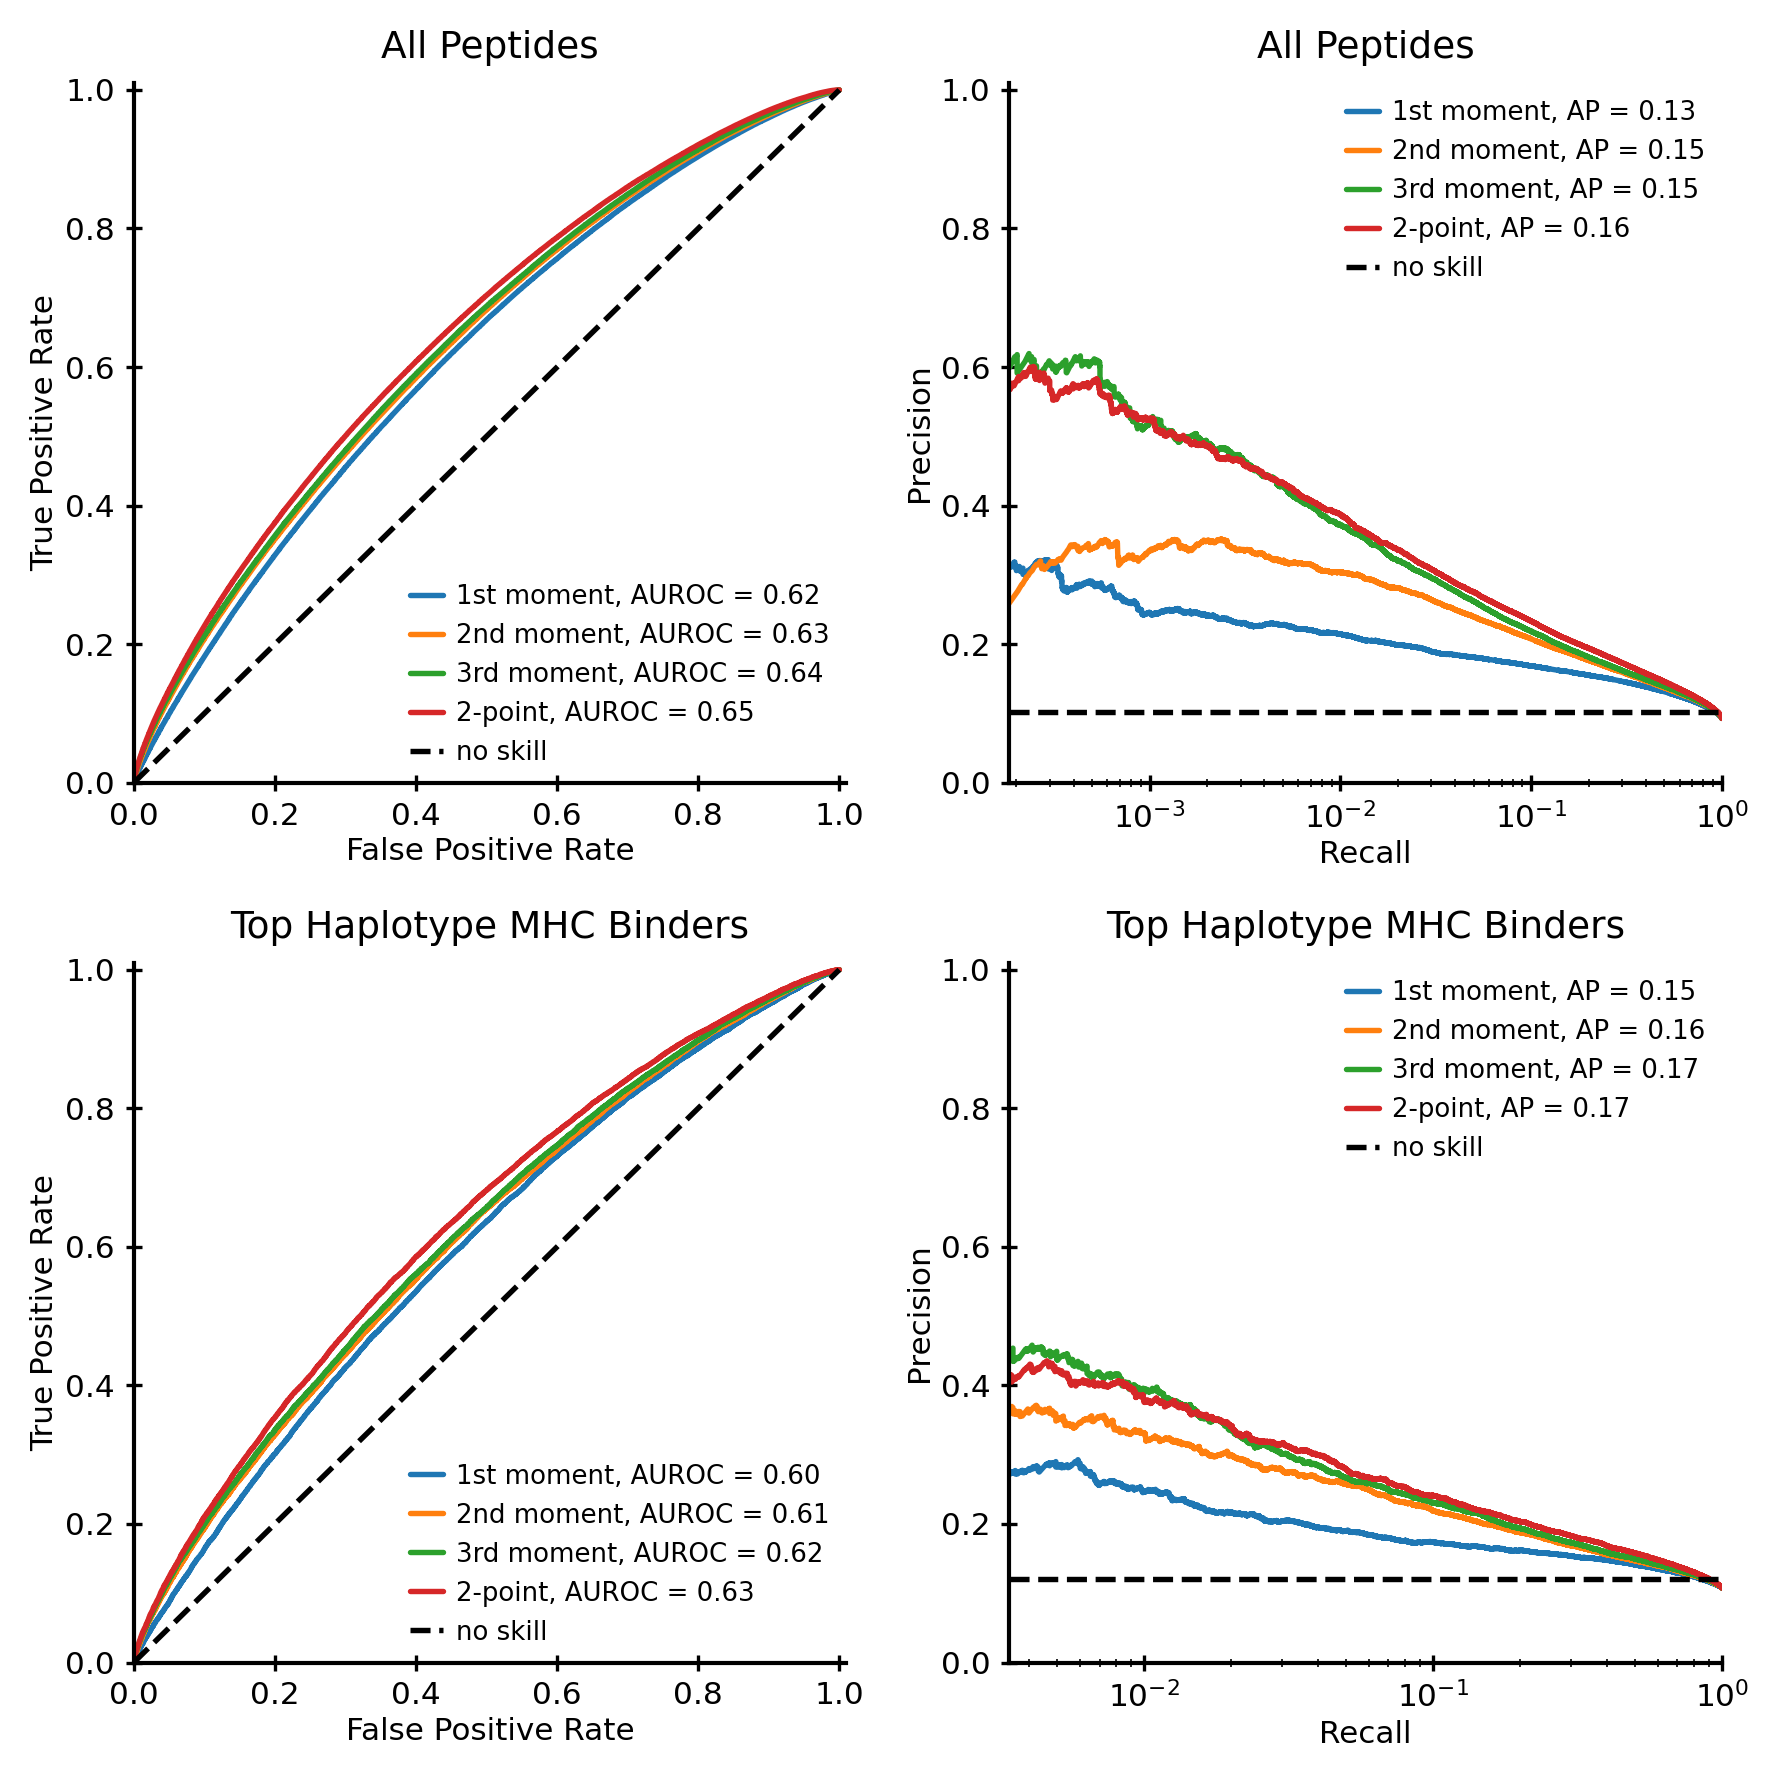

In [14]:
fig, axes = plt.subplots(figsize=(6, 6), ncols=2, nrows=2)


ax = axes[0,0]
for model, class_data in results.items():
    ax.plot(class_data['fpr'], class_data['tpr'],
            label=f'{model_mapper[model]}, AUROC = %0.2f' % class_data['roc_auc'])
    
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='no skill')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0))
ax.legend(loc='lower right')

ax.set_title('All Peptides')


ax = axes[1,0]
for model, class_data in results.items():
    ax.plot(class_data['fpr_mhc'], class_data['tpr_mhc'],
            label=f'{model_mapper[model]}, AUROC = %0.2f' % class_data['roc_auc_mhc'])
    
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='no skill')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0))
ax.legend(loc='lower right')


ax.set_title('Top Haplotype MHC Binders')




ax = axes[0,1]
for model, class_data in results.items():
    ax.plot(class_data['recall'], class_data['precision'],
            label=f'{model_mapper[model]}, AP = %0.2f' % class_data['average_precision'])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/class_data['negative_excess'], c='k', ls='--', label='no skill')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_vv), 1.0)
# ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))
ax.legend(loc='upper right')

ax.set_title('All Peptides')


ax = axes[1,1]
for model, class_data in results.items():
    ax.plot(class_data['recall_mhc'], class_data['precision_mhc'],
            label=f'{model_mapper[model]}, AP = %0.2f' % class_data['average_precision_mhc'])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/class_data['negative_excess_mhc'], c='k', ls='--', label='no skill')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_vv_mhc), 1.0)
ax.legend(loc='upper right')
ax.set_title('Top Haplotype MHC Binders')

fig.tight_layout()

# plt.savefig('plots/mhc_roc_top_haplotype.png')

In [16]:
cols = ["A1","A2","B1","B2","C1","C2"]
haplotypes = pd.read_csv("../data/generated_data/top_500_allowed_haplotypes.txt",names=cols)

In [17]:

CACHE = {
    'Humanviruses_test': {},
    'Human_test': {}
    
    
}

def get_mhc_df(model, allele):
    try:
        return pd.read_csv(f'../data/generated_data/netMHC_output/net_mhc_output_{model}-{allele}.csv')
    except Exception as e:
        print(f'Missing CSV: {model},{allele}')
        return None
        
def get_combined_binders(model, alleles):

    kmers = set()
    for allele in alleles:
        
        if allele in CACHE[model]:
            kmers = kmers.union(CACHE[model][allele])
        
        else:
            mhc_df = get_mhc_df(model, allele)
            if mhc_df is not None:
                try:
                    s = set(mhc_df['Peptide'])
                    kmers = kmers.union(s)
                    CACHE[model][allele] = s
                except Exception as e:
                    print(f'Messed up CSV: {model},{allele}')
                    print(e)
    return kmers

In [ ]:
# do it for all haplotypes for nskewfcov model

logp_dict = {}
model = 'nskewfcov'


# human values with and without MHC
energy_human = make_energy(np.load(f'../data/generated_data/Human_{model}_k9_params.npz'))
F_human = float(pd.read_csv(f"../data/generated_data/Human_{model}_k9_entropy.csv",header=None, index_col=0).loc['F'].values[0])
loglikelihood_human  = lambda seq: -energy_human(seq) + F_human


# virus values with and without MHC
energy_virus = make_energy(np.load(f'../data/generated_data/Humanviruses_{model}_k9_params.npz'))
F_virus = float(pd.read_csv(f'../data/generated_data/Humanviruses_{model}_k9_entropy.csv',header=None, index_col=0).loc['F'].values[0])
loglikelihood_virus  = lambda seq: -energy_virus(seq) + F_virus

human_matrix = load_matrix('../data/generated_data/Human_test_k9_matrix.csv.gz')
virus_matrix = load_matrix('../data/generated_data/Humanviruses_test_k9_matrix.csv.gz')


roc_values = []
ap_values = []
    
for idx,haplotype in haplotypes.iterrows():
    print(idx)
    
    human_binders = get_combined_binders('Human_test', list(haplotype))

    human_kmers = matrix_to_kmers(human_matrix)
    human_kmers_mhc = [km for km in human_kmers if km in human_binders]
    human_matrix_mhc = kmers_to_matrix(human_kmers_mhc)

    virus_binders = get_combined_binders('Humanviruses_test', list(haplotype))
    virus_kmers = matrix_to_kmers(virus_matrix)
    virus_kmers_mhc = [km for km in virus_kmers if km in virus_binders]
    virus_matrix_mhc = kmers_to_matrix(virus_kmers_mhc)
    
    
    logp_hh_mhc = np.array([loglikelihood_human(kmer) for kmer in human_matrix_mhc])
    logp_hv_mhc = np.array([loglikelihood_virus(kmer) for kmer in human_matrix_mhc])
    logp_vv_mhc = np.array([loglikelihood_virus(kmer) for kmer in virus_matrix_mhc])
    logp_vh_mhc = np.array([loglikelihood_human(kmer) for kmer in virus_matrix_mhc])

    
    class_data = {}

    
    # mhc restricted data
    positive_mhc = logp_vv_mhc-logp_vh_mhc #likelihood ratio for virus kmers
    negative_mhc = logp_hv_mhc-logp_hh_mhc #likelihood ratio for human kmers
    y_true_mhc = np.concatenate([np.ones(len(positive_mhc)), np.zeros(len(negative_mhc))])
    y_score_mhc = np.concatenate([positive_mhc, negative_mhc])
    fpr_mhc, tpr_mhc, thresholds_roc_mhc = roc_curve(y_true_mhc, y_score_mhc)
    roc_auc_mhc = auc(fpr_mhc, tpr_mhc)
    
    roc_values.append(roc_auc_mhc)

    precision_mhc, recall_mhc, thresholds_pr_mhc = precision_recall_curve(y_true_mhc, y_score_mhc)
    average_precision_mhc = average_precision_score(y_true_mhc, y_score_mhc)
    ap_values.append(average_precision_mhc)

    
    

In [11]:
results_write = {
    'roc_values': roc_values,
    'ap_values': ap_values
}
with open('data/roc_mhc_analysis.json', 'w') as fp:
    json.dump(results_write, fp)

In [21]:
with open('../data/generated_data/roc_mhc_analysis.json', 'r') as fp:
    results = json.load(fp)

Text(0.5, 0.98, 'Classification Results for all haplotypes')

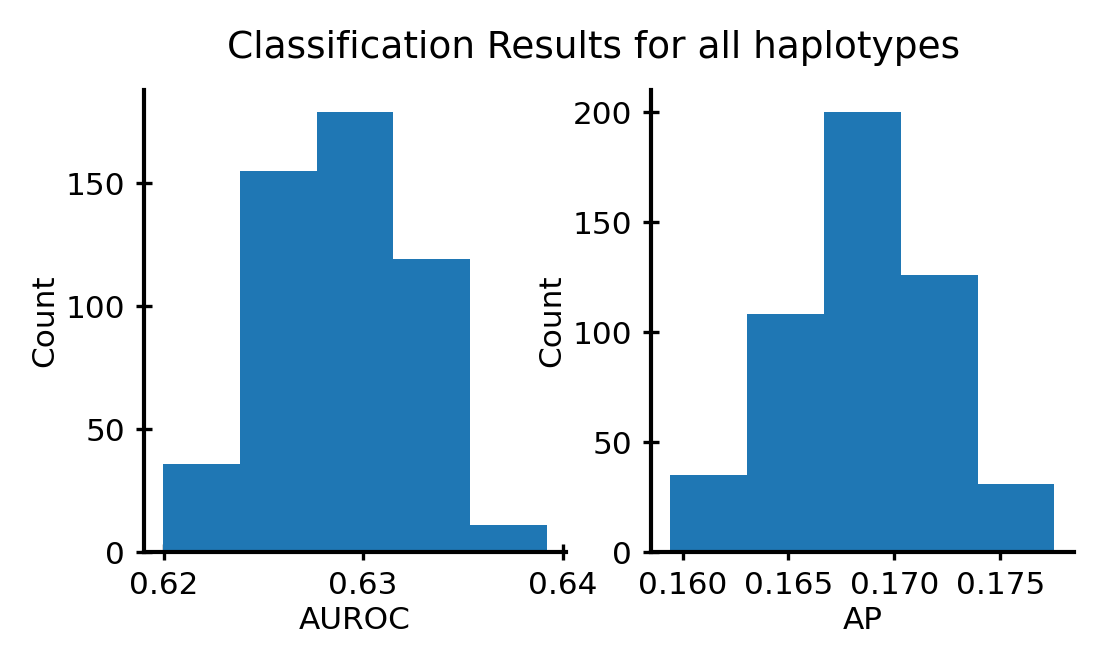

In [23]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.hist(results['roc_values'],5)
plt.ylabel('Count')
plt.xlabel('AUROC')
plt.subplot(1,2,2)
plt.hist(results['ap_values'],5)
plt.ylabel('Count')
plt.xlabel('AP')
plt.suptitle('Classification Results for all haplotypes')
# plt.savefig('plots/roc_ap_all_haplotypes.png')

In [2]:
models = ['independent', 'ncov', 'nskew', 'nskewfcov']
for model in models:
    humanviruses_model = load_matrix(f'../maxent/data/mcmc_thermo/Humanviruses_{model}_1e7_60_matrix.csv.gz')
    kmers = matrix_to_kmers(humanviruses_model)
    with open(f"data/netMHC_input/net_mhc_input_Humanviruses_{model}_1e7_60.txt",'w') as f:
        for item in kmers:
            f.write(f"{item}\n")